In [35]:
import scanpy as sc
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

from contextlib import contextmanager
from tqdm import tqdm

In [2]:
import torch
import pyro

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
import echidna as ec
ec.pl.activate_plot_settings()

In [5]:
%load_ext autoreload
%autoreload 2

# Functions for running experiments

In [6]:
import copy

In [7]:
def grid_search_configs(base_config, param, param_vals):
    config = base_config
    if not hasattr(config, param):
        raise AttributeError(f"'No attribute '{param}'")
    
    all_config = []
    for val in param_vals:
        config_ = copy.deepcopy(config)
        setattr(config_, param, val)
        assert getattr(config_, param) == val
        all_config.append(config_)
    return all_config

In [8]:
def run_one_model(adata, w, ec_config):
  # set random seed across multiple repeats
  ec_config.seed = torch.randint(0, 2**32, (1,)).item()
  # set timepoints orders
  ec.tl.set_sort_order(
    adata,
    ["pre", "on", "on1", "on2", "post", "post1", "post1_pre2", "post1_on2", "post2"]
  )
  
  ec.tl.echidna_train(
     adata
    ,w
    ,ec_config
  )
  
  trained_model = ec.tl.load_model(adata)
  eta = trained_model.eta_posterior.detach().cpu().numpy()
  c = trained_model.c_posterior.detach().cpu().numpy()
  cov = trained_model.cov_posterior.detach().cpu().numpy()
  corr = trained_model.corr_posterior.detach().cpu().numpy()
  
  return eta, c, cov, corr
  

In [9]:
def load_multiple_adatas(file_path, n):
    adatas = []
    for _ in range(n):
        adata = sc.read_h5ad(file_path)
        adatas.append(adata)
    return adatas

In [10]:
from scipy.stats import pearsonr, spearmanr
import gc

In [11]:
def compute_metrics(x, y, metric="corr_p"):
    if metric == 'corr_p':
        return pearsonr(x, y)[0]
    elif metric == 'corr_s':
        return spearmanr(x, y)[0]
    elif metric == 'frob':
        return np.linalg.norm(x - y, ord='fro')
    else:
        raise AttributeError("Invalid metric")

In [12]:
import os
import gzip
import tempfile

In [13]:
import tqdm

In [14]:
def run_experiment_hp(data_path, w, ground_truth_params, hyper_param_of_interest, base_config, values, num_repeats=5):
    eta_gt, c_gt, cov_gt, corr_gt = ground_truth_params
    all_configs = grid_search_configs(base_config, hyper_param_of_interest, values)
    scores = {}
    for local_config in tqdm.tqdm(all_configs):
        config_val = getattr(local_config, hyper_param_of_interest)
        scores_one_config_eta, scores_one_config_c, scores_one_config_cov, scores_one_config_corr = [], [], [], []
        for _ in range(num_repeats):
            adata = sc.read_h5ad(data_path)
            eta, c, cov, corr = run_one_model(adata, w, local_config)
            scores_one_config_eta.append(compute_metrics(eta.flatten(), eta_gt.flatten(), 'corr_p'))
            scores_one_config_c.append(compute_metrics(c.flatten(), c_gt.flatten(), 'corr_p'))
            scores_one_config_cov.append(compute_metrics(cov, cov_gt, 'frob'))
            scores_one_config_corr.append(compute_metrics(corr, corr_gt, 'frob'))
            
            del adata
            gc.collect()
            
        scores[config_val] = {
            'eta': scores_one_config_eta,
            'c': scores_one_config_c,
            'cov': scores_one_config_cov,
            'corr': scores_one_config_corr,
        }
    return scores

def run_experiment_cell_subsample(data_path, w, ground_truth_params, base_config, subsample_perc, num_repeats=5):
    eta_gt, c_gt, cov_gt, corr_gt = ground_truth_params
    adata_full = sc.read_h5ad(data_path)
    adata_list = [sc.pp.subsample(adata_full, fraction=f, copy=True) for f in subsample_perc]
    scores = {}
    i = 0
    for adata_sub in tqdm.tqdm(adata_list):
        config_val = subsample_perc[i]
        scores_one_config_eta, scores_one_config_c, scores_one_config_cov, scores_one_config_corr = [], [], [], []
        for _ in range(num_repeats):
            eta, c, cov, corr = run_one_model(adata_sub, w, base_config)
            scores_one_config_eta.append(compute_metrics(eta.flatten(), eta_gt.flatten(), 'corr_p'))
            scores_one_config_c.append(compute_metrics(c.flatten(), c_gt.flatten(), 'corr_p'))
            scores_one_config_cov.append(compute_metrics(cov, cov_gt, 'frob'))
            scores_one_config_corr.append(compute_metrics(corr, corr_gt, 'frob'))
            
        del adata_sub
        gc.collect()
            
        scores[config_val] = {
            'eta': scores_one_config_eta,
            'c': scores_one_config_c,
            'cov': scores_one_config_cov,
            'corr': scores_one_config_corr,
        }
        i += 1
    return scores

# Get ground truth parameters

In [15]:
adata = sc.read_h5ad("/home/mingxuanzhang/echidna/data/R310.h5ad")

In [16]:
wdf = pd.read_csv("/home/mingxuanzhang/echidna/data/all_cellranger_w.csv", index_col=0).set_index("gene")
wdf = wdf[['R310_pre_count', 'R310_on2_count']]
wdf

,R310_pre_count,R310_on2_count
gene,,
HES4,0.282645,0.282645
ISG15,2.000000,2.000000
AL645608.1,2.000000,2.000000
AGRN,2.000000,2.000000
AL645608.5,2.000000,2.000000
...,...,...
SMC5,1.000000,1.000000
AL162390.1,1.000000,1.000000
KLF9,1.000000,1.000000


In [17]:
ec.tl.set_sort_order(
    adata,
    ["pre", "on", "on1", "on2", "post", "post1", "post1_pre2", "post1_on2", "post2"]
)

In [18]:
num_timepoints = 2
num_clusters = len(adata.obs["leiden"].unique())
q_corr_init = 1e-2
q_shape_rate_scaler = 10.0
eta_mean_init = 2.0
lkj_concentration = 1.0

In [19]:
config = ec.tl.EchidnaConfig(
    timepoint_label = "condition",
    counts_layer = "counts",
    clusters = "leiden",
    inverse_gamma = False,
    eta_mean_init = 2.,
    patience = -1,
    learning_rate = .1,
    num_timepoints = num_timepoints,
    num_clusters = num_clusters,
    q_corr_init = q_corr_init,
    q_shape_rate_scaler = q_shape_rate_scaler,
    n_steps=500,
)

2025-04-04 06:52:13,281 | INFO : Added `.obs['echidna_split']`: the Echidna train/validation split.
 381 cells in validation set.
2025-04-04 06:52:13,296 | INFO : Added `.var[echidna_matched_genes]` : Labled True for genes contained in W.
2025-04-04 06:52:13,303 | INFO : Added `.var[echidna_W_R310_pre_count]` : CN entries for genes contained in W.


2025-04-04 06:52:13,304 | INFO : Added `.var[echidna_W_R310_on2_count]` : CN entries for genes contained in W.
2025-04-04 06:52:13,305 | WARNING : `leiden` changed to `leiden_categorical`.
/home/mingxuanzhang/echidna/echidna/tools/train.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2 4 2 ... 3 3 5]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  adata.obs.loc[:, config.clusters] = pd.Categorical(adata.obs.loc[:,config.clusters]).codes
training loss: 0.7867 | validation loss: 0.1328: 100%|██████████████████████████████████████| 500/500 [01:25<00:00,  5.85it/s]


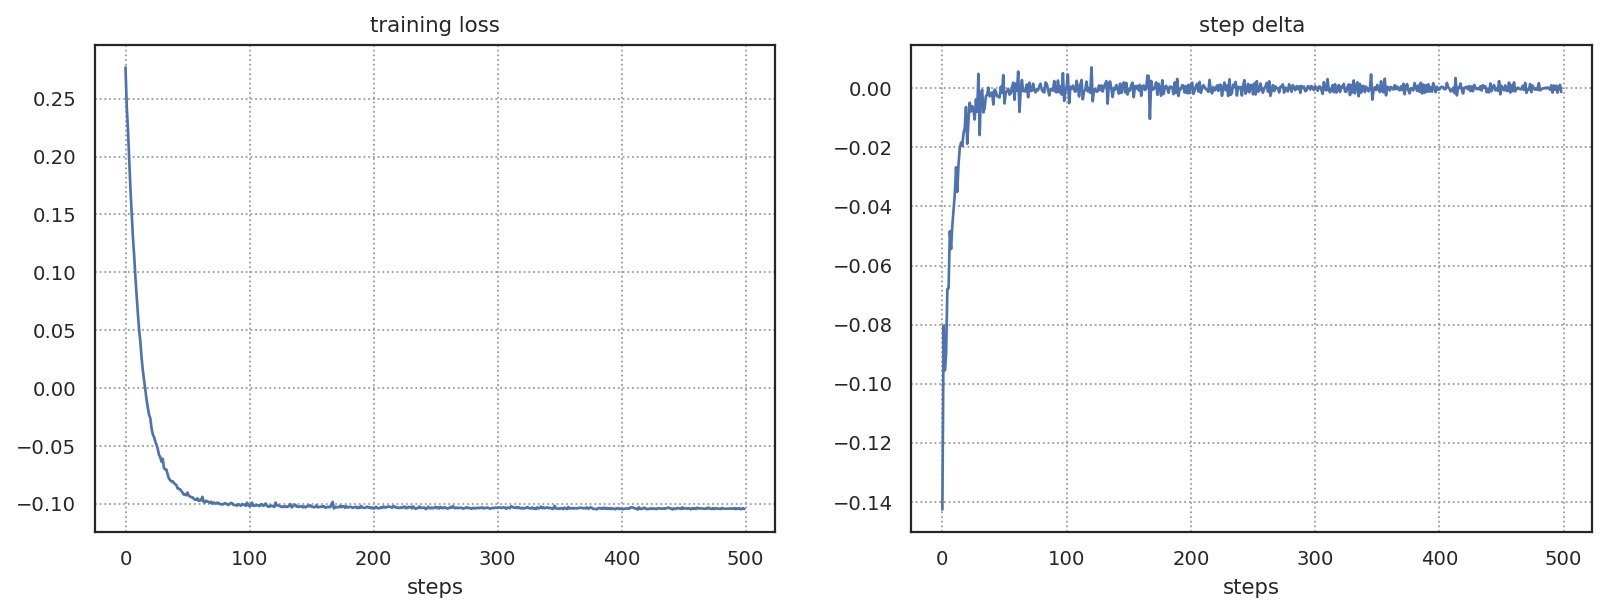

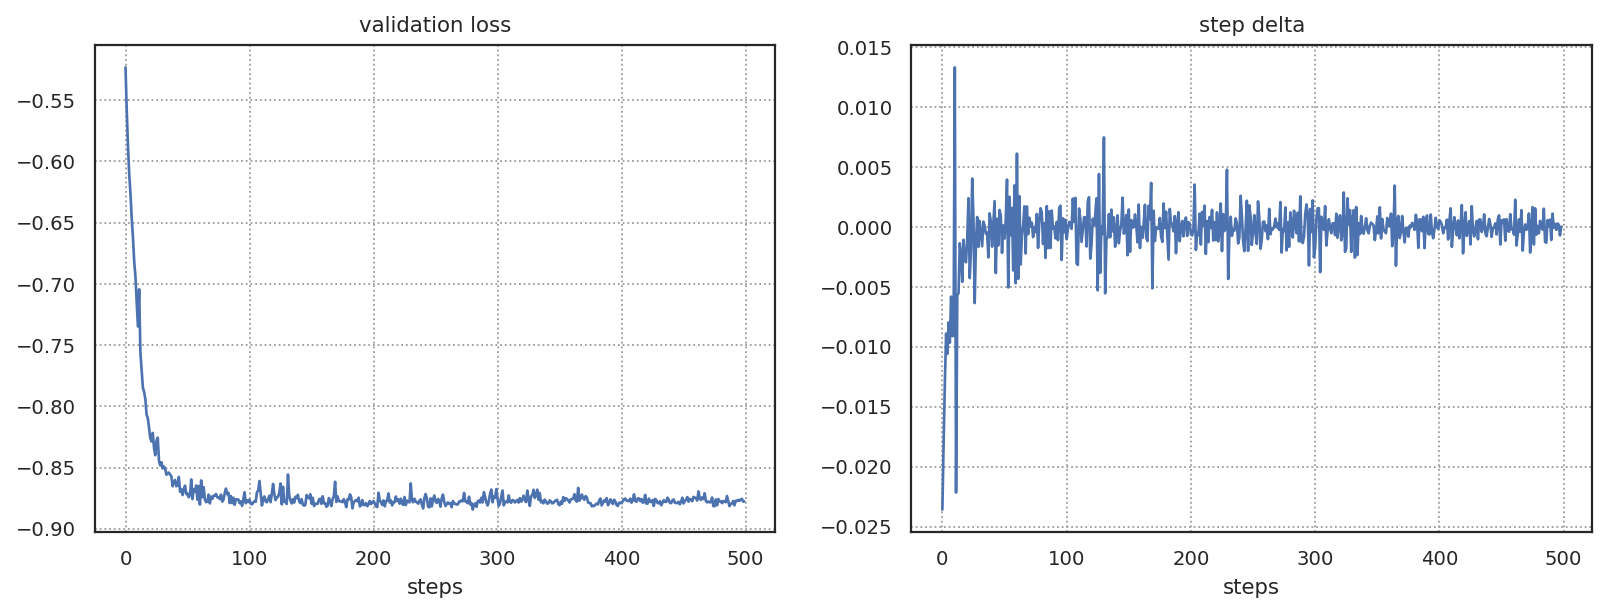

2025-04-04 06:54:15,528 | INFO : Saving echidna model with run_id 20250404-065415.


In [20]:
ec.tl.echidna_train(
     adata
    , wdf
    , config
)

/home/mingxuanzhang/echidna/echidna/tools/eval.py:362: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hier_colors = [color_dict.loc[int(i)][0] for i in adata.obs[cluster_label]]
2025-04-04 06:54:16,519 | INFO : Added `.obs['echidna_clones']`: the learned clones from eta.


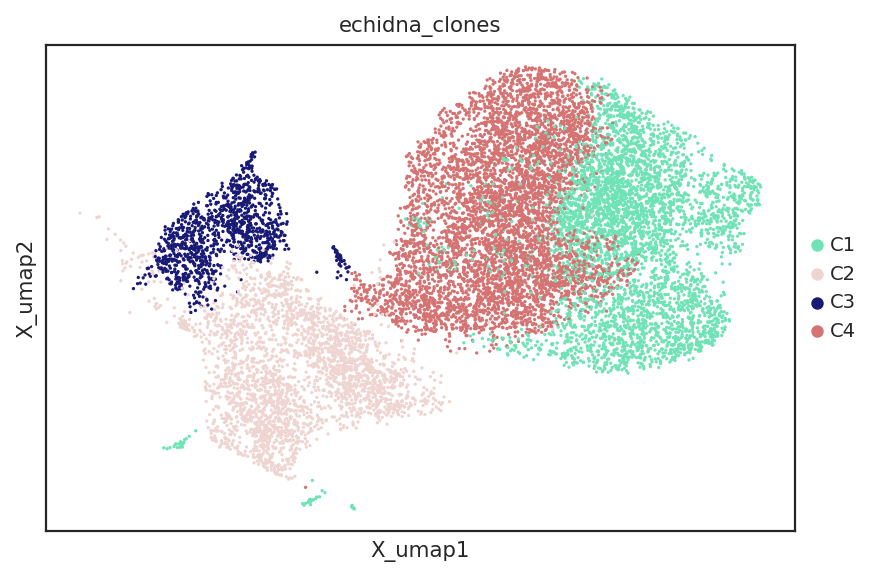

In [21]:
ec.tl.echidna_clones(adata, threshold=0.1)
ec.pl.echidna(adata)

In [22]:
gt_model = ec.tl.load_model(adata)
ground_truth_params = (
    gt_model.eta_posterior.detach().cpu().numpy(),
    gt_model.c_posterior.detach().cpu().numpy(),
    gt_model.cov_posterior.detach().cpu().numpy(),
    gt_model.corr_posterior.detach().cpu().numpy()
)

# Hyperparam 1: q_corr_init

In [36]:
config.patience = 30
scores = run_experiment_hp(
    data_path="/home/mingxuanzhang/echidna/data/R310.h5ad",
    w = wdf,
    ground_truth_params=ground_truth_params,
    hyper_param_of_interest='q_corr_init',
    base_config=config,
    values=[1e-4, 1e-3, 1e-1, 2e-1],
    num_repeats=5
)

In [53]:
import pickle
with open("q_init_corr_scores.pkl", "wb") as file:
    pickle.dump(scores, file)

In [36]:
import pickle
scores = pickle.load(open("q_init_corr_scores.pkl", "rb"))

<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\e'
/var/tmp/ipykernel_41999/4143697314.py:19: SyntaxWarning: invalid escape sequence '\e'
  plt.title("Robustness of $\eta$ across different q_corr_init", fontsize=22)
/var/tmp/ipykernel_41999/4143697314.py:21: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel("Pearson $R$ to ground truth $\eta$", fontsize=22)
2025-07-22 03:38:01,141 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-07-22 03:38:01,148 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


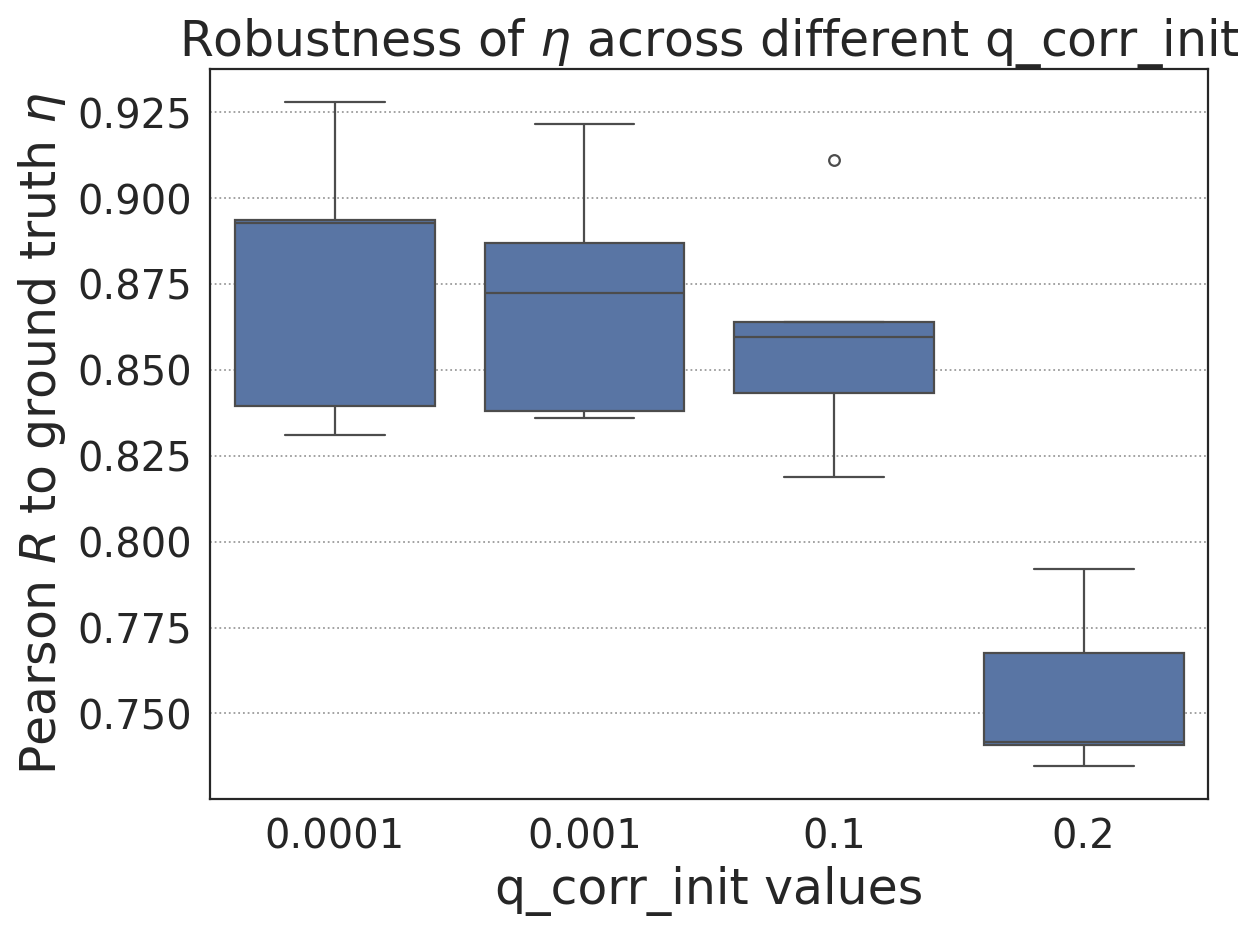

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

eta_data = []
for hp_val, metrics in scores.items():
    if hp_val == 0.5:
        continue
    for score in metrics['eta']:
        eta_data.append({"Hyperparameter": hp_val, "Score": score})

df_eta = pd.DataFrame(eta_data)

# Plotting using seaborn
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x="Hyperparameter", y="Score", data=df_eta)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
plt.title("Robustness of $\eta$ across different q_corr_init", fontsize=22)
plt.xlabel("q_corr_init values", fontsize=22)
plt.ylabel("Pearson $R$ to ground truth $\eta$", fontsize=22)
plt.savefig("q_corr_robustness_eta.svg", format="svg", bbox_inches='tight', dpi=300)

plt.show()

2025-07-22 03:38:13,059 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-22 03:38:13,065 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


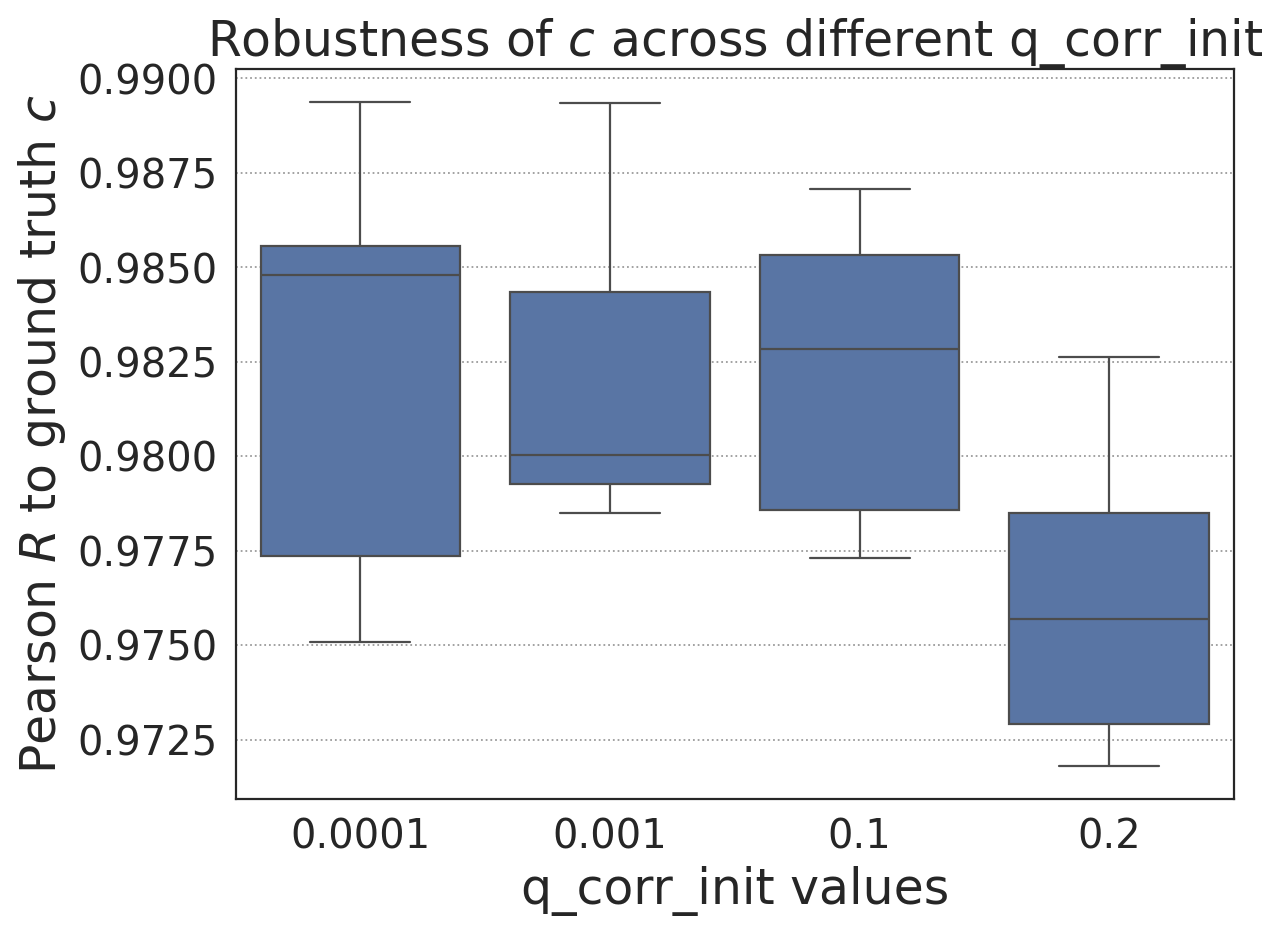

In [38]:
eta_data = []
for hp_val, metrics in scores.items():
    if hp_val == 0.5:
        continue
    for score in metrics['c']:
        eta_data.append({"Hyperparameter": hp_val, "Score": score})

df_eta = pd.DataFrame(eta_data)

# Plotting using seaborn
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x="Hyperparameter", y="Score", data=df_eta)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
plt.title("Robustness of $c$ across different q_corr_init", fontsize=22)
plt.xlabel("q_corr_init values", fontsize=22)
plt.ylabel("Pearson $R$ to ground truth $c$", fontsize=22)
plt.savefig("q_corr_robustness_c.svg", format="svg", bbox_inches='tight', dpi=300)
plt.show()

<>:15: SyntaxWarning: invalid escape sequence '\S'
<>:15: SyntaxWarning: invalid escape sequence '\S'
/var/tmp/ipykernel_41999/1438299720.py:15: SyntaxWarning: invalid escape sequence '\S'
  plt.title("Robustness of $\Sigma$ across different q_corr_init", fontsize=22)
2025-07-22 03:38:17,543 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-22 03:38:17,549 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


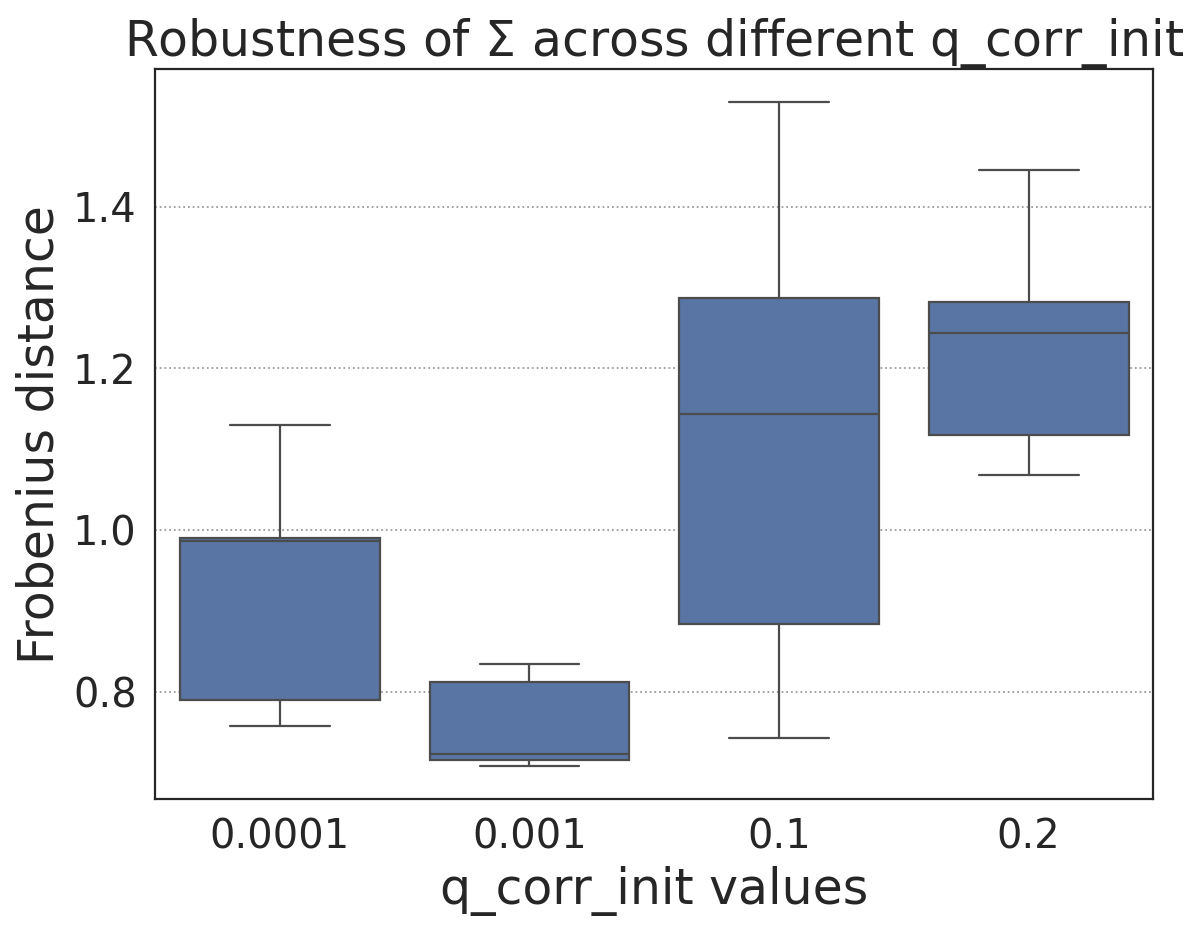

In [39]:
eta_data = []
for hp_val, metrics in scores.items():
    if hp_val == 0.5:
        continue
    for score in metrics['cov']:
        eta_data.append({"Hyperparameter": hp_val, "Score": score})

df_eta = pd.DataFrame(eta_data)

# Plotting using seaborn
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x="Hyperparameter", y="Score", data=df_eta)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
plt.title("Robustness of $\Sigma$ across different q_corr_init", fontsize=22)
plt.xlabel("q_corr_init values", fontsize=22)
plt.ylabel("Frobenius distance", fontsize=22)
plt.savefig("q_corr_robustness_sigma.svg", format="svg", bbox_inches='tight', dpi=300)
plt.show()

# Hyperparam 2: LKJ concentration

In [ ]:
config.patience = 30
scores = run_experiment_hp(
    data_path="/home/mingxuanzhang/echidna/data/R310.h5ad",
    w = wdf,
    ground_truth_params=ground_truth_params,
    hyper_param_of_interest='lkj_concentration',
    base_config=config,
    values=[0.2, 0.5, 1.2, 1.5],
    num_repeats=5
)

In [58]:
import pickle
with open("lkj_con_scores.pkl", "wb") as file:
    pickle.dump(scores, file)

In [40]:
scores = pickle.load(open("lkj_con_scores.pkl", "rb"))

<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:15: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:15: SyntaxWarning: invalid escape sequence '\e'
/var/tmp/ipykernel_41999/1447497556.py:13: SyntaxWarning: invalid escape sequence '\e'
  plt.title("Robustness of $\eta$ across different LKJ concentrations", fontsize=22)
/var/tmp/ipykernel_41999/1447497556.py:15: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel("Pearson $R$ to ground truth $\eta$", fontsize=22)
2025-07-22 03:38:29,477 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-22 03:38:29,483 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


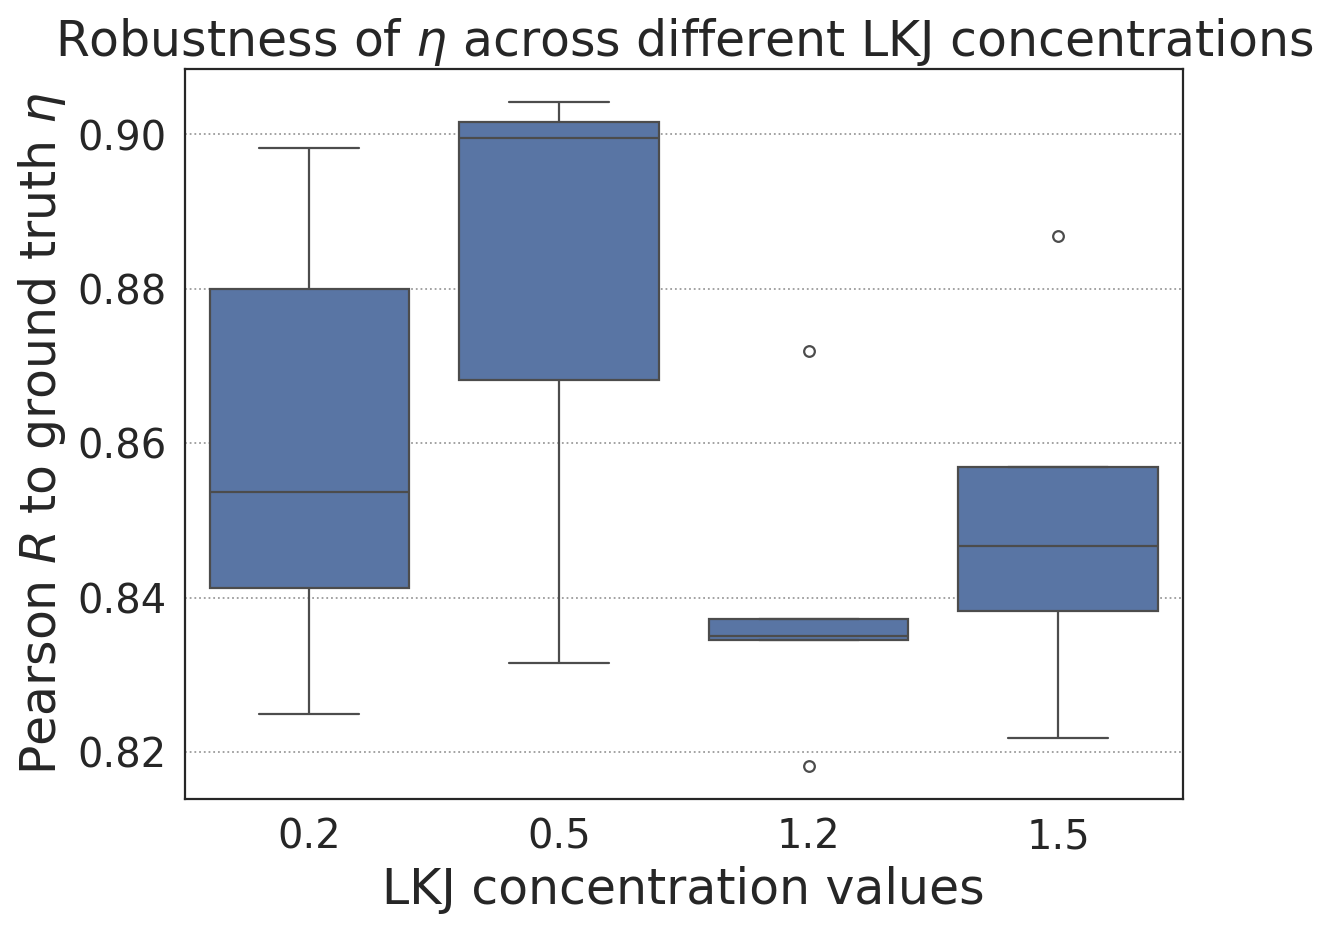

In [41]:
eta_data = []
for hp_val, metrics in scores.items():
    for score in metrics['eta']:
        eta_data.append({"Hyperparameter": hp_val, "Score": score})

df_eta = pd.DataFrame(eta_data)

# Plotting using seaborn
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x="Hyperparameter", y="Score", data=df_eta)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
plt.title("Robustness of $\eta$ across different LKJ concentrations", fontsize=22)
plt.xlabel("LKJ concentration values", fontsize=22)
plt.ylabel("Pearson $R$ to ground truth $\eta$", fontsize=22)
plt.savefig("lkj_concentration_robustness_eta.svg", format="svg", bbox_inches='tight', dpi=300)
plt.show()

2025-07-22 03:38:36,297 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-22 03:38:36,303 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


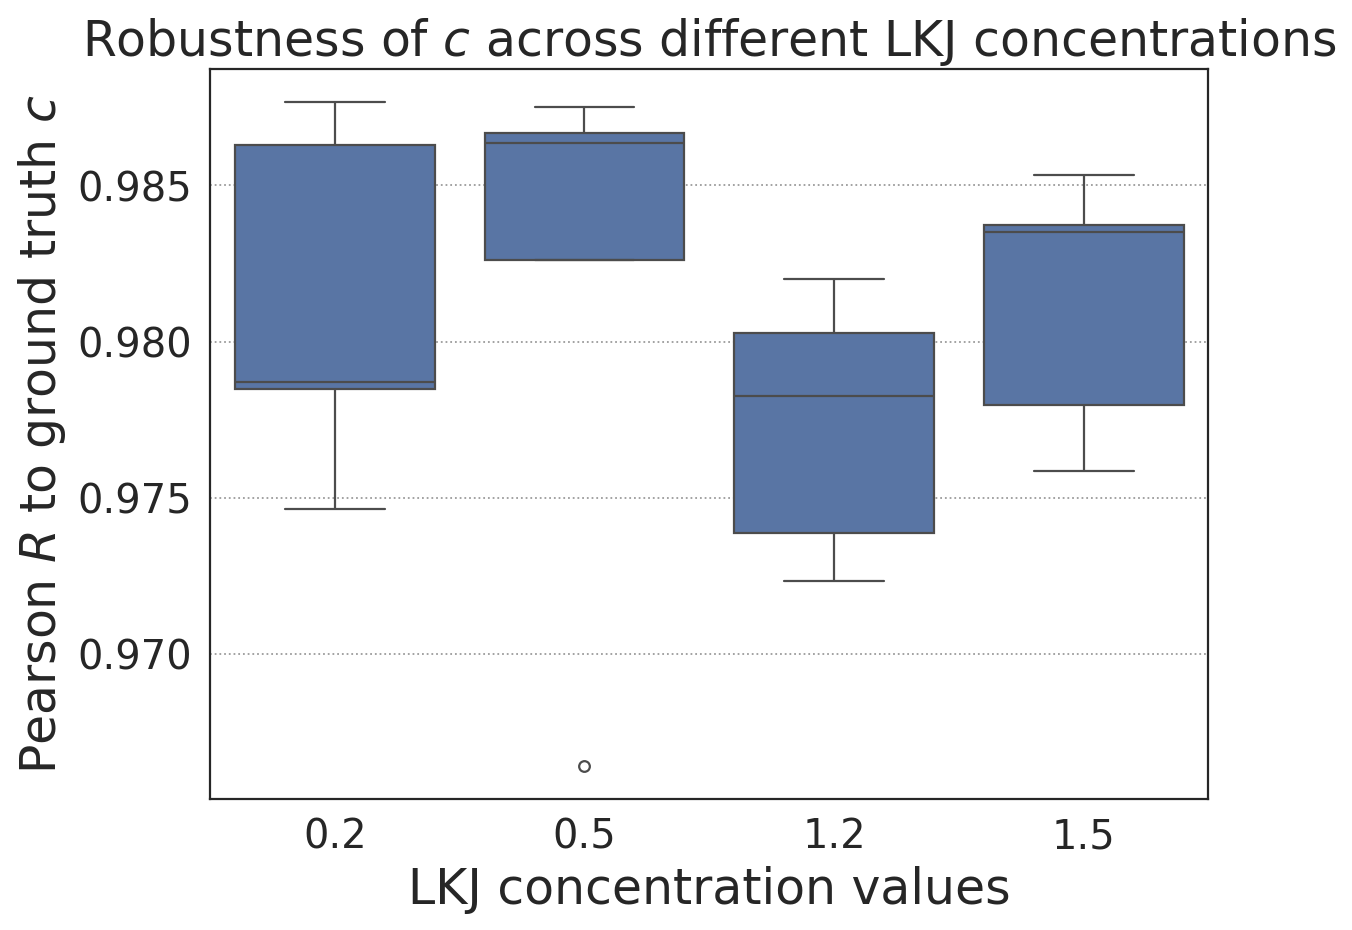

In [42]:
eta_data = []
for hp_val, metrics in scores.items():
    for score in metrics['c']:
        eta_data.append({"Hyperparameter": hp_val, "Score": score})

df_eta = pd.DataFrame(eta_data)

# Plotting using seaborn
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x="Hyperparameter", y="Score", data=df_eta)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
plt.title("Robustness of $c$ across different LKJ concentrations", fontsize=22)
plt.xlabel("LKJ concentration values", fontsize=22)
plt.ylabel("Pearson $R$ to ground truth $c$", fontsize=22)
plt.savefig("lkj_concentration_robustness_c.svg", format="svg", bbox_inches='tight', dpi=300)
plt.show()

<>:13: SyntaxWarning: invalid escape sequence '\S'
<>:13: SyntaxWarning: invalid escape sequence '\S'
/var/tmp/ipykernel_41999/4092605412.py:13: SyntaxWarning: invalid escape sequence '\S'
  plt.title("Robustness of $\Sigma$ across different LKJ concentrations", fontsize=22)
2025-07-22 03:38:41,401 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-07-22 03:38:41,409 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


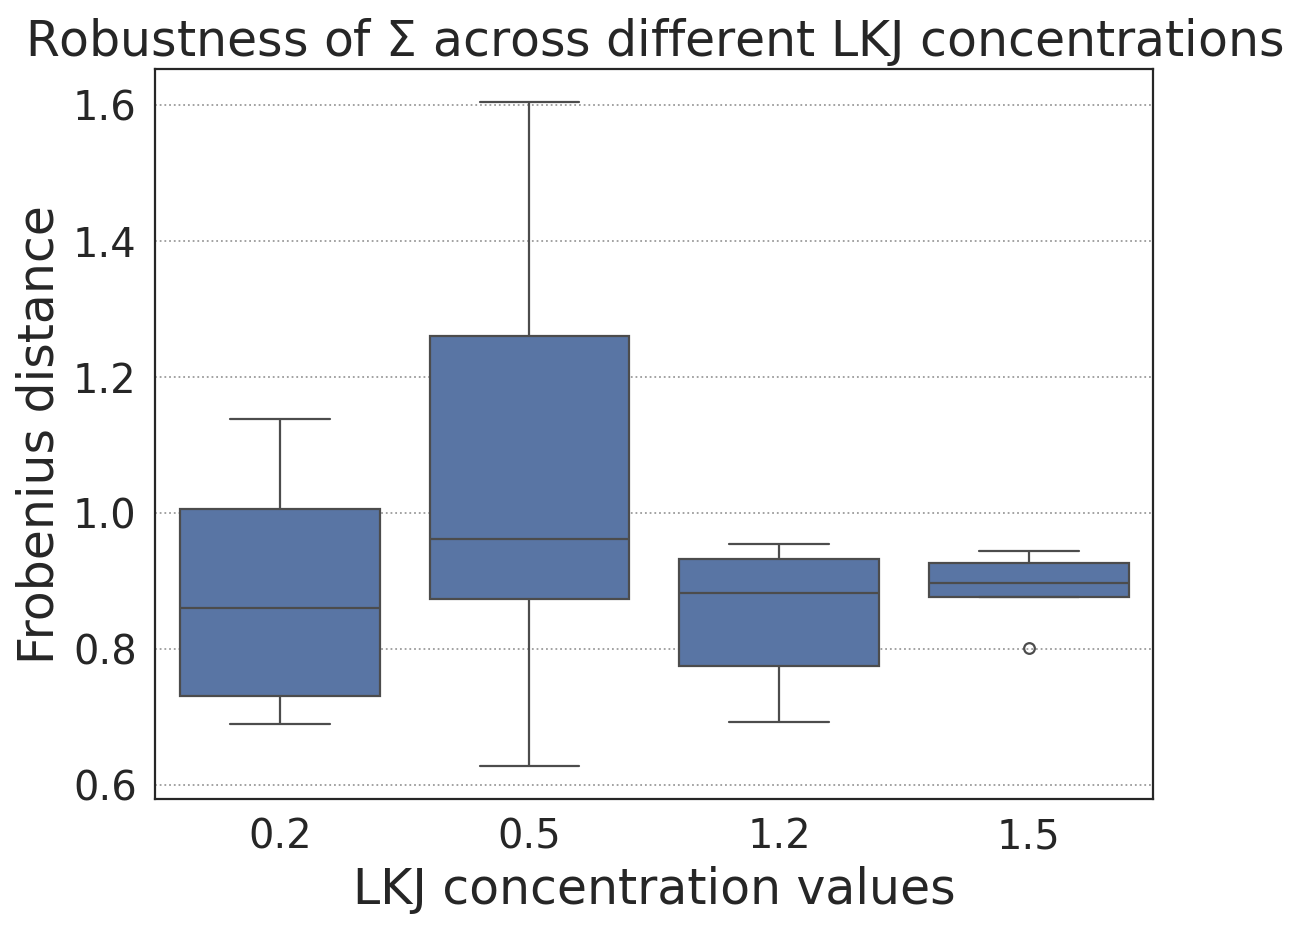

In [43]:
eta_data = []
for hp_val, metrics in scores.items():
    for score in metrics['cov']:
        eta_data.append({"Hyperparameter": hp_val, "Score": score})

df_eta = pd.DataFrame(eta_data)

# Plotting using seaborn
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x="Hyperparameter", y="Score", data=df_eta)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
plt.title("Robustness of $\Sigma$ across different LKJ concentrations", fontsize=22)
plt.xlabel("LKJ concentration values", fontsize=22)
plt.ylabel("Frobenius distance", fontsize=22)
plt.savefig("lkj_concentration_robustness_sigma.svg", format="svg", bbox_inches='tight', dpi=300)
plt.show()

# Subsampling cells

In [ ]:
config.patience = 30
scores = run_experiment_cell_subsample(
    data_path="/home/mingxuanzhang/echidna/data/R310.h5ad",
    w=wdf,
    ground_truth_params=ground_truth_params,
    base_config=config,
    subsample_perc=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    num_repeats=5
)

In [44]:
scores = pickle.load(open("cell_subsample_scores.pkl", "rb"))

<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:15: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:15: SyntaxWarning: invalid escape sequence '\e'
/var/tmp/ipykernel_41999/2870219658.py:13: SyntaxWarning: invalid escape sequence '\e'
  plt.title("Robustness of $\eta$ across subsample percentage", fontsize=22)
/var/tmp/ipykernel_41999/2870219658.py:15: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel("Pearson $R$ to ground truth $\eta$", fontsize=22)
2025-07-22 03:38:48,285 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-22 03:38:48,291 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


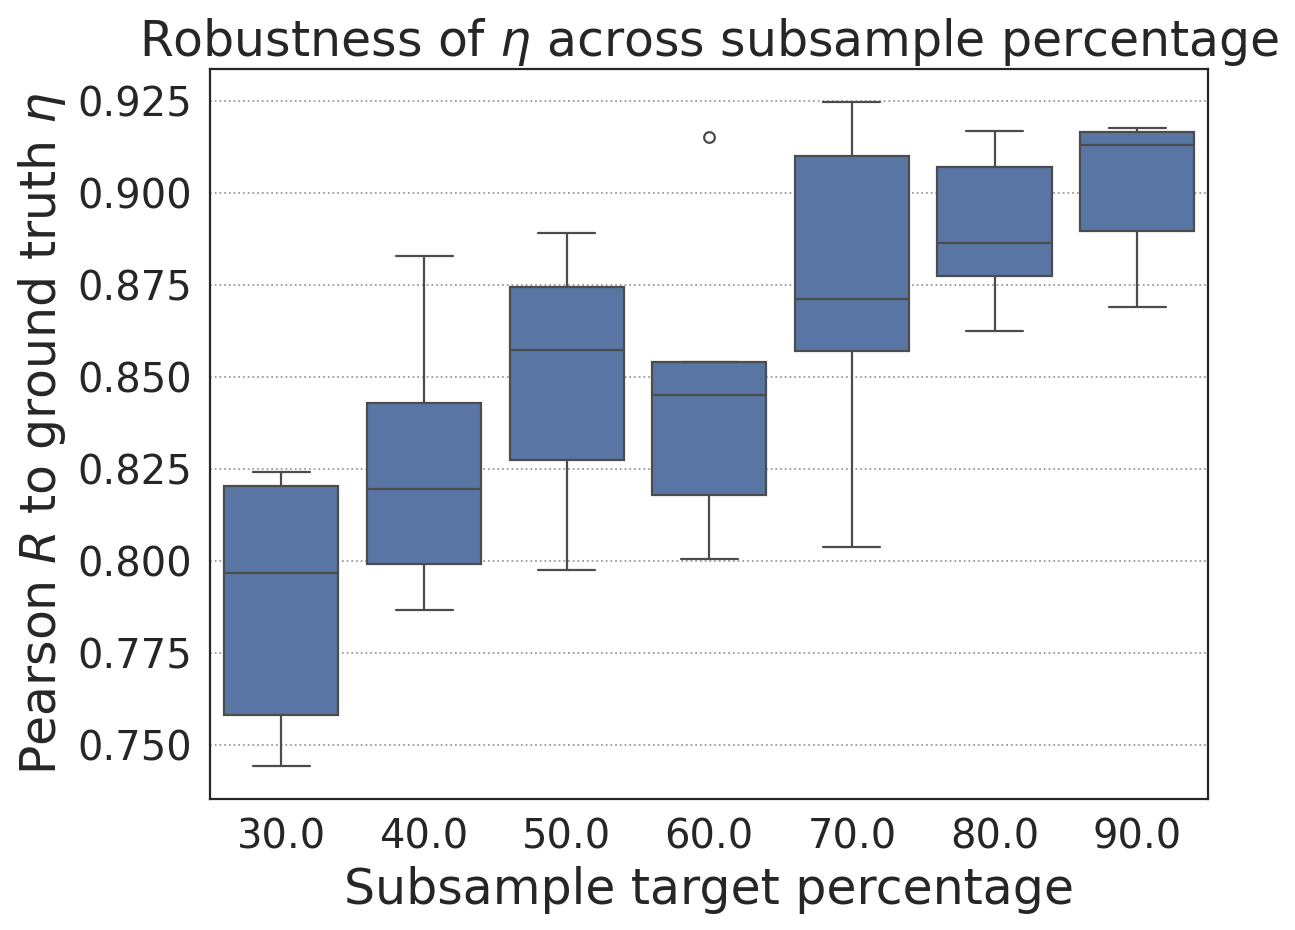

In [45]:
eta_data = []
for hp_val, metrics in scores.items():
    for score in metrics['eta']:
        eta_data.append({"Hyperparameter": hp_val * 100, "Score": score})

df_eta = pd.DataFrame(eta_data)

# Plotting using seaborn
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x="Hyperparameter", y="Score", data=df_eta)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
plt.title("Robustness of $\eta$ across subsample percentage", fontsize=22)
plt.xlabel("Subsample target percentage", fontsize=22)
plt.ylabel("Pearson $R$ to ground truth $\eta$", fontsize=22)
plt.savefig("cell_subsample_robustness_eta.svg", format="svg", bbox_inches='tight', dpi=300)
plt.show()

2025-07-22 03:38:53,966 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-22 03:38:53,974 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


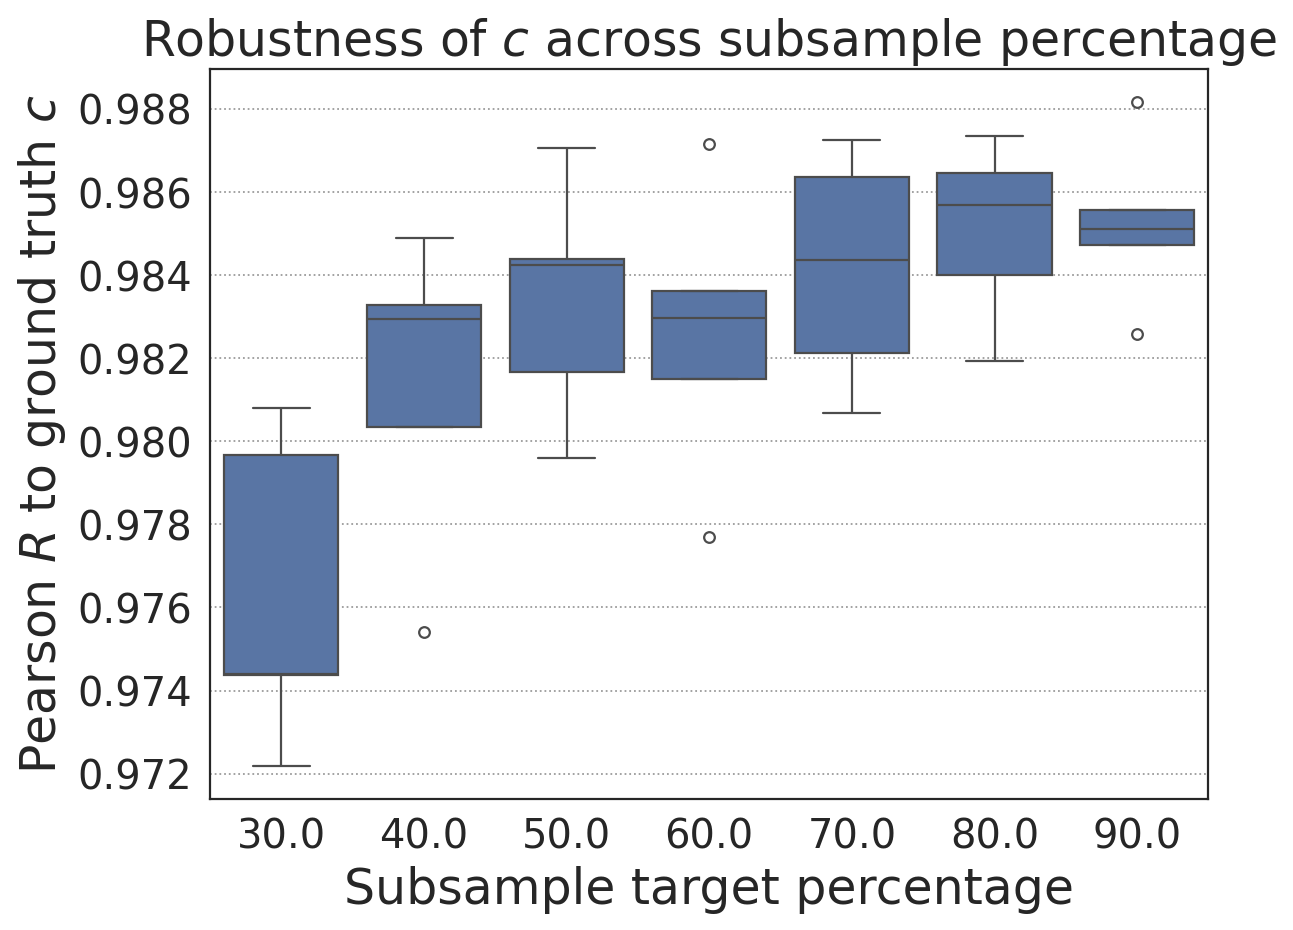

In [46]:
eta_data = []
for hp_val, metrics in scores.items():
    for score in metrics['c']:
        eta_data.append({"Hyperparameter": hp_val * 100, "Score": score})

df_eta = pd.DataFrame(eta_data)

# Plotting using seaborn
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x="Hyperparameter", y="Score", data=df_eta)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
plt.title("Robustness of $c$ across subsample percentage", fontsize=22)
plt.xlabel("Subsample target percentage", fontsize=22)
plt.ylabel("Pearson $R$ to ground truth $c$", fontsize=22)
plt.savefig("cell_subsample_robustness_c.svg", format="svg", bbox_inches='tight', dpi=300)
plt.show()

<>:13: SyntaxWarning: invalid escape sequence '\S'
<>:13: SyntaxWarning: invalid escape sequence '\S'
/var/tmp/ipykernel_41999/3729215864.py:13: SyntaxWarning: invalid escape sequence '\S'
  plt.title("Robustness of $\Sigma$ across subsample percentage", fontsize=22)
2025-07-22 03:39:06,445 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-22 03:39:06,452 | INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


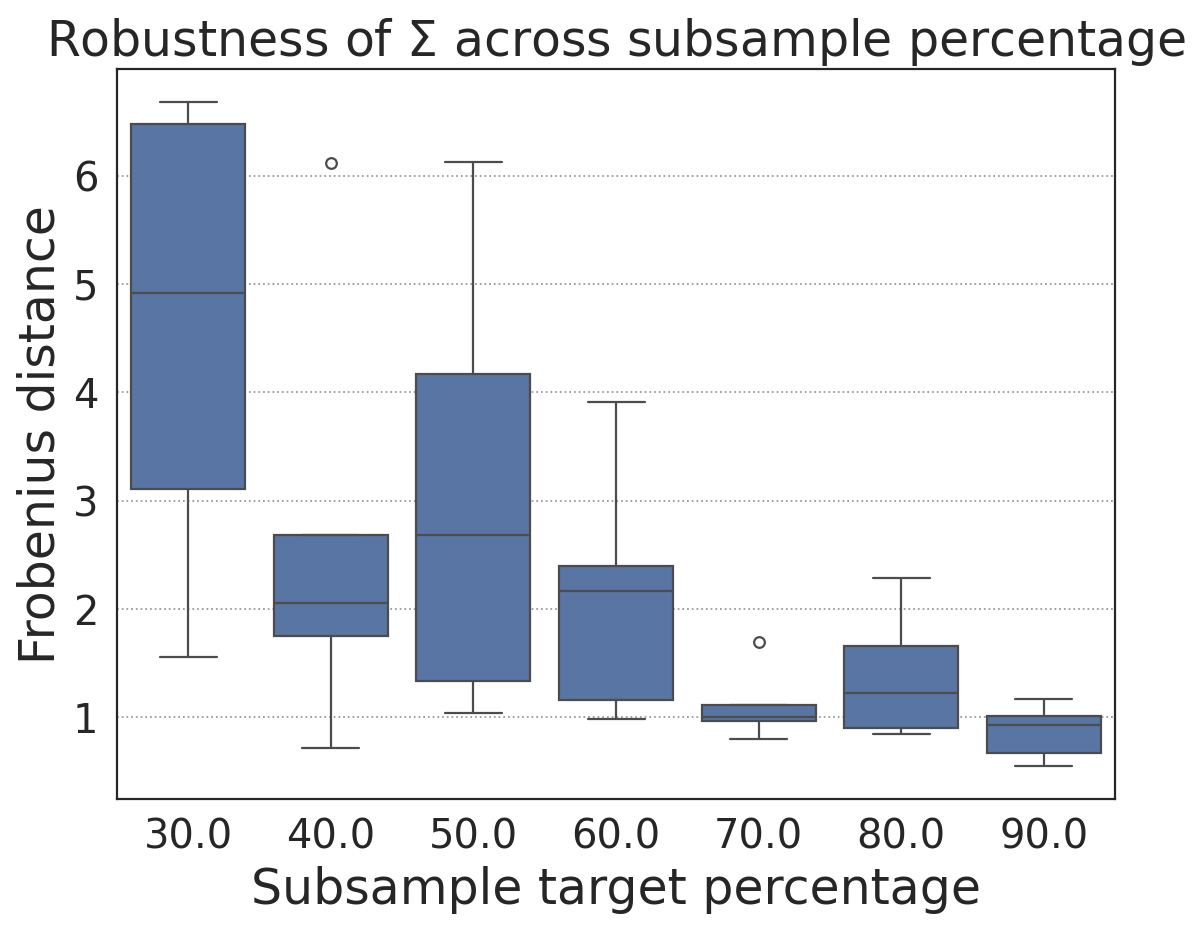

In [47]:
eta_data = []
for hp_val, metrics in scores.items():
    for score in metrics['cov']:
        eta_data.append({"Hyperparameter": hp_val * 100, "Score": score})

df_eta = pd.DataFrame(eta_data)

# Plotting using seaborn
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x="Hyperparameter", y="Score", data=df_eta)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
plt.title("Robustness of $\Sigma$ across subsample percentage", fontsize=22)
plt.xlabel("Subsample target percentage", fontsize=22)
plt.ylabel("Frobenius distance", fontsize=22)
plt.savefig("cell_subsample_robustness_sigma.svg", format="svg", bbox_inches='tight', dpi=300)
plt.show()

In [30]:
scores.keys()

dict_keys([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [31]:
import pickle
with open("cell_subsample_scores.pkl", "wb") as file:
    pickle.dump(scores, file)